In [653]:
from tvDatafeed import TvDatafeed, Interval

In [654]:
username = 'mashgh2'
password = 'Amin1380ali'
tv = TvDatafeed(username, password)

ERROR:tvDatafeed.main:error while signin


In [655]:
# get data
df_XUD = tv.get_hist(symbol='XAUUSD',exchange='OANDA',interval=Interval.in_5_minute,n_bars=5000)
#correct timing
import pandas as pd
# # Offset the index by 3.5 hours
# offset = pd.Timedelta(hours=3.5)
# df_XUD.index = df_XUD.index - offset




In [656]:
df_XUD_4H = tv.get_hist(symbol='XAUUSD',exchange='OANDA',interval=Interval.in_4_hour,n_bars=144)
# offset = pd.Timedelta(hours=3.5)
# df_XUD_4H.index = df_XUD_4H.index - offset
# Add SMA 20
window_size = 20
df_XUD_4H['SMA 20'] = df_XUD_4H['close'].rolling(window=window_size).mean()

# Calculate the difference between current and previous day's closing price
df_XUD_4H['price_diff_CO'] = df_XUD_4H['close'] -  df_XUD_4H['open']

# Add a new column to indicate green (1) or red (0)
df_XUD_4H['candle color'] = df_XUD_4H['price_diff_CO'].apply(lambda x: 'green' if x > 0 else 'red')


def above_or_below_SMA20(row):
    # if((row['close'] > row['SMA 20'] and row['open'] < row['SMA 20']) or (row['close']  < row['SMA 20'] and row['open'] > row['SMA 20'])):
    #     return 'no position' # return defulat
    if ((row['close'] > row['SMA 20'])):
        return 'above' 
    elif ((row['close'] < row['SMA 20'])):
        return 'below'
    else:
        return  'no position' # return defulat

df_XUD_4H['above_or_below'] = df_XUD_4H.apply(above_or_below_SMA20, axis=1)
df_XUD_4H['above_or_below_shifted'] = df_XUD_4H['above_or_below'].shift(1)

df_XUD_4H.to_csv('4_hour.csv', index=True)

In [657]:
gold_mini_change_to_set_order = 0.3
gold_value_stop = 0.1

In [658]:
def get_macd_12(df_XUD):


    # Assuming your DataFrame is named df
    short_window = 12  # Short-term EMA
    long_window = 26   # Long-term EMA
    signal_window = 9  # Signal line EMA

    # Calculate Short-term EMA
    df_XUD['EMA_short_12'] = df_XUD['close'].ewm(span=short_window, adjust=False).mean()

    # Calculate Long-term EMA
    df_XUD['EMA_long_12'] = df_XUD['close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    df_XUD['MACD_12'] = df_XUD['EMA_short_12'] - df_XUD['EMA_long_12']

    # Calculate Signal line (Signal line is typically a 9-period EMA of MACD values)
    df_XUD['Signal_Line_12'] = df_XUD['MACD_12'].ewm(span=signal_window, adjust=False).mean()

    # Calculate MACD Histogram
    df_XUD['MACD_Histogram'] = df_XUD['MACD_12'] - df_XUD['Signal_Line_12']

    # Determine MACD trend direction (Above/Below Zero Line)
    df_XUD['MACD_Trend_12'] = df_XUD['MACD_12'].apply(lambda x: 'Above' if x > 0 else 'Below')

    # Determine Signal_Line trend direction (Above/Below Zero Line)
    df_XUD['Signal_Line_Trend_12'] = df_XUD['Signal_Line_12'].apply(lambda x: 'Above' if x > 0 else 'Below')


    # Determine Histogram color (Green if MACD > Signal Line, Red otherwise)
    df_XUD['Hist_color_V1'] = df_XUD.apply(lambda row: 'green' if row['MACD_12'] > row['Signal_Line_12'] else 'red', axis=1)


    # Function to determine color based on conditions
    def determine_color(row):
        if row['MACD_Histogram'] > 0 and abs(row['MACD_Histogram']) > abs(row['MACD_Histogram_shifted']):
            return 'green'  # Signal Line is below MACD and Histogram is increasing
        elif row['MACD_Histogram'] > 0 and abs(row['MACD_Histogram']) < abs(row['MACD_Histogram_shifted']):
            return 'light green'  # Signal Line is above MACD and Histogram is decreasing
        elif row['MACD_Histogram'] < 0 and abs(row['MACD_Histogram']) > abs(row['MACD_Histogram_shifted']):
            return 'red'  # Signal Line is above MACD and Histogram is decreasing
        else:
            return 'light red'  # Signal Line is above MACD and Histogram is not decreasing

    # Calculate the shift of the MACD_Histogram column
    df_XUD['MACD_Histogram_shifted'] = df_XUD['MACD_Histogram'].shift(1)

    # Apply the determine_color function to create the color column
    df_XUD['Hist_color_V2'] = df_XUD.apply(determine_color, axis=1)

    # Function to determine color based on conditions
    def determine_color_finisher(row):
        if (row['Hist_color_V2_shifted'] ==  'light green' or row['Hist_color_V2_shifted'] ==  'green') and row['Hist_color_V2'] == "light red":
            return 'red'  # fix first hist candle
        elif (row['Hist_color_V2_shifted'] ==  'light red' or row['Hist_color_V2_shifted'] ==  'red') and row['Hist_color_V2'] == "light green":
            return 'green'  # fix first hist candle
        else:
            return  row['Hist_color_V2'] # return defulat

    # Calculate the shift of the MACD_Histogram column
    df_XUD['Hist_color_V2_shifted'] = df_XUD['Hist_color_V2'].shift(1)

    # Advaned level: GOD bless me
    df_XUD['Hist_color_V3_12'] = df_XUD.apply(determine_color_finisher, axis=1)


    # Create a cross counter column
    counter = 0
    counter_list = []
    prev_color = None

    for color in df_XUD['Hist_color_V1']:
        if prev_color is None or color == prev_color:
            counter += 1
        else:
            counter = 1
        counter_list.append(counter)
        prev_color = color

    df_XUD['cross_counter'] = counter_list
    return df_XUD

In [659]:
def get_macd_27(df_XUD):


    # Assuming your DataFrame is named df
    short_window = 27  # Short-term EMA
    long_window = 26   # Long-term EMA
    signal_window = 9  # Signal line EMA

    # Calculate Short-term EMA
    df_XUD['EMA_short_27'] = df_XUD['close'].ewm(span=short_window, adjust=False).mean()

    # Calculate Long-term EMA
    df_XUD['EMA_long_27'] = df_XUD['close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    df_XUD['MACD_27'] = df_XUD['EMA_short_27'] - df_XUD['EMA_long_27']

    # Calculate Signal line (Signal line is typically a 9-period EMA of MACD values)
    df_XUD['Signal_Line_27'] = df_XUD['MACD_27'].ewm(span=signal_window, adjust=False).mean()

    # Calculate MACD Histogram
    df_XUD['MACD_Histogram'] = df_XUD['MACD_27'] - df_XUD['Signal_Line_27']

    # Determine MACD trend direction (Above/Below Zero Line)
    df_XUD['MACD_Trend_27'] = df_XUD['MACD_27'].apply(lambda x: 'Above' if x > 0 else 'Below')

    # Determine Signal_Line trend direction (Above/Below Zero Line)
    df_XUD['Signal_Line_Trend_27'] = df_XUD['Signal_Line_27'].apply(lambda x: 'Above' if x > 0 else 'Below')


    # Determine Histogram color (Green if MACD > Signal Line, Red otherwise)
    df_XUD['Hist_color_V1'] = df_XUD.apply(lambda row: 'green' if row['MACD_27'] > row['Signal_Line_27'] else 'red', axis=1)


    # Function to determine color based on conditions
    def determine_color(row):
        if row['MACD_Histogram'] > 0 and abs(row['MACD_Histogram']) > abs(row['MACD_Histogram_shifted']):
            return 'green'  # Signal Line is below MACD and Histogram is increasing
        elif row['MACD_Histogram'] > 0 and abs(row['MACD_Histogram']) < abs(row['MACD_Histogram_shifted']):
            return 'light green'  # Signal Line is above MACD and Histogram is decreasing
        elif row['MACD_Histogram'] < 0 and abs(row['MACD_Histogram']) > abs(row['MACD_Histogram_shifted']):
            return 'red'  # Signal Line is above MACD and Histogram is decreasing
        else:
            return 'light red'  # Signal Line is above MACD and Histogram is not decreasing

    # Calculate the shift of the MACD_Histogram column
    df_XUD['MACD_Histogram_shifted'] = df_XUD['MACD_Histogram'].shift(1)

    # Apply the determine_color function to create the color column
    df_XUD['Hist_color_V2'] = df_XUD.apply(determine_color, axis=1)

    # Function to determine color based on conditions
    def determine_color_finisher(row):
        if (row['Hist_color_V2_shifted'] ==  'light green' or row['Hist_color_V2_shifted'] ==  'green') and row['Hist_color_V2'] == "light red":
            return 'red'  # fix first hist candle
        elif (row['Hist_color_V2_shifted'] ==  'light red' or row['Hist_color_V2_shifted'] ==  'red') and row['Hist_color_V2'] == "light green":
            return 'green'  # fix first hist candle
        else:
            return  row['Hist_color_V2'] # return defulat

    # Calculate the shift of the MACD_Histogram column
    df_XUD['Hist_color_V2_shifted'] = df_XUD['Hist_color_V2'].shift(1)

    # Advaned level: GOD bless me
    df_XUD['Hist_color_V3_27'] = df_XUD.apply(determine_color_finisher, axis=1)


    # Create a cross counter column
    counter = 0
    counter_list = []
    prev_color = None

    for color in df_XUD['Hist_color_V1']:
        if prev_color is None or color == prev_color:
            counter += 1
        else:
            counter = 1
        counter_list.append(counter)
        prev_color = color

    df_XUD['cross_counter'] = counter_list
    return df_XUD

In [660]:
# Add SMA 20
window_size = 20
df_XUD['SMA 20'] = df_XUD['close'].rolling(window=window_size).mean()

# Calculate the difference between current and previous day's closing price
df_XUD['price_diff_CO'] = df_XUD['close'] -  df_XUD['open']

# Add a new column to indicate green (1) or red (0)
df_XUD['candle color'] = df_XUD['price_diff_CO'].apply(lambda x: 'green' if x > 0 else 'red')

df_XUD = get_macd_12(df_XUD)

def determine_candle_from_sma20(row):
    if (row['SMA 20'] > row['low']  and row['SMA 20'] < row['close']  and row['candle color'] == 'green'):
        return 'buy' 
    elif (row['SMA 20'] > row['close']  and row['SMA 20'] < row['high']  and row['candle color'] == 'red') :
        return 'sell'  
    else:
        return  '' # return defulat

df_XUD['inside candle (rule 1)'] = df_XUD.apply(determine_candle_from_sma20, axis=1)

def determine_distance_sma20(row):
    if (row['inside candle (rule 1)'] == 'buy'):
        return (row['high'] - row['SMA 20'] ) 
    elif (row['inside candle (rule 1)'] == 'sell') :
        return row['SMA 20'] - row['low']
    else:
        return  'no position' # return defulat

df_XUD['distance SMA 20 from high or close'] = df_XUD.apply(determine_distance_sma20, axis=1)


# from distance where sma 20 get broke and the candle closed , it shouldn't bigger than 4 other candles 
df_XUD['candle_size'] = df_XUD['high'] - df_XUD['low']
df_XUD['candle_size_shifted1'] = df_XUD['candle_size'].shift(1)
df_XUD['candle_size_shifted2'] = df_XUD['candle_size'].shift(2)
df_XUD['candle_size_shifted3'] = df_XUD['candle_size'].shift(3)
df_XUD['candle_size_shifted4'] = df_XUD['candle_size'].shift(4)

def determine_rule2(row):
    if row['distance SMA 20 from high or close'] == 'no position':
        return "False"
    elif (row['distance SMA 20 from high or close'] < row['candle_size_shifted4'] or row['distance SMA 20 from high or close'] < row['candle_size_shifted2'] or row['distance SMA 20 from high or close'] < row['candle_size_shifted3'] or row['distance SMA 20 from high or close'] < row['candle_size_shifted1']):
        return "True"  
    else:
        return  'False'

df_XUD['rule_2'] = df_XUD.apply(determine_rule2, axis=1)  

def determine_rule3_12(row):
    if (row['MACD_Trend_12'] == 'Above'  and row['Signal_Line_Trend_12'] == 'Above') :
        return "buy"
    elif (row['MACD_Trend_12'] == 'Above'  and row['Signal_Line_Trend_12'] == 'Below'):
        return "Half_buy"  
    elif (row['MACD_Trend_12'] == 'Below'  and row['Signal_Line_Trend_12'] == 'Below'):
        return "sell"  
    else:
        return  'Half_sell'

df_XUD['rule_3_12'] = df_XUD.apply(determine_rule3_12, axis=1) 

#for long sabz kamrang and for short germez kamrang?
def determine_rule4_5(row):
    if (row['inside candle (rule 1)'] == 'buy'  and row['Hist_color_V3_12'] == 'light red' and row['cross_counter'] >= 4  ) :
        return "buy"
    elif (row['inside candle (rule 1)'] == 'buy'  and row['Hist_color_V3_12'] == 'light green' ) :
        return "buy"
    elif (row['inside candle (rule 1)'] == 'buy'  and row['Hist_color_V3_12'] == 'green' and row['cross_counter'] <= 2 ):
        return "buy"
    elif (row['inside candle (rule 1)'] == 'sell'  and row['Hist_color_V3_12'] == 'light green' and row['cross_counter'] >= 4 ) :
        return "sell"
    elif (row['inside candle (rule 1)'] == 'sell'  and row['Hist_color_V3_12'] == 'light red' ) :
        return "sell"
    elif (row['inside candle (rule 1)'] == 'sell'  and row['Hist_color_V3_12'] == 'red' and row['cross_counter'] <= 2 ):
        return "sell"

    else:
        return  'unknown'

df_XUD['rule_4_5'] = df_XUD.apply(determine_rule4_5, axis=1) 

df_XUD = get_macd_27(df_XUD)
def determine_rule3_27(row):
    if (row['MACD_Trend_27'] == 'Above'  and row['Signal_Line_Trend_27'] == 'Above') :
        return "buy"
    elif (row['MACD_Trend_27'] == 'Above'  and row['Signal_Line_Trend_27'] == 'Below'):
        return "Half_buy"  
    elif (row['MACD_Trend_27'] == 'Below'  and row['Signal_Line_Trend_27'] == 'Below'):
        return "sell"  
    else:
        return  'Half_sell'

df_XUD['rule_3_27'] = df_XUD.apply(determine_rule3_27, axis=1) 

#for long sabz kamrang and for short germez kamrang?
def determine_rule4_5_macd27(row):
    if (row['inside candle (rule 1)'] == 'buy' and ( row['Hist_color_V3_27'] == 'light red' or row['Hist_color_V3_27'] == 'red') and row['cross_counter'] <= 3) :
        return "buy"
    elif (row['inside candle (rule 1)'] == 'sell'  and ( row['Hist_color_V3_27'] == 'light green' or row['Hist_color_V3_27'] == 'green') and row['cross_counter']<= 3) :
        return "sell"
    else:
        return  'unknown'

df_XUD['rule_4_5_macd27'] = df_XUD.apply(determine_rule4_5_macd27, axis=1) 

df_XUD['SL_sell_shifted1'] = df_XUD['high'].shift(1)
df_XUD['SL_sell_shifted2'] = df_XUD['high'].shift(2)
df_XUD['SL_sell_shifted3'] = df_XUD['high'].shift(3)
df_XUD['SL_sell_shifted4'] = df_XUD['high'].shift(4)

df_XUD['SL_buy_shifted1'] = df_XUD['low'].shift(1)
df_XUD['SL_buy_shifted2'] = df_XUD['low'].shift(2)
df_XUD['SL_buy_shifted3'] = df_XUD['low'].shift(3)
df_XUD['SL_buy_shifted4'] = df_XUD['low'].shift(4)

def determine_SL_buy(row):
   return min(row['SL_buy_shifted1'],row['SL_buy_shifted2'],row['SL_buy_shifted3'],row['SL_buy_shifted4']) - 0.1

def determine_SL_sell(row):
   return max(row['SL_sell_shifted1'],row['SL_sell_shifted2'],row['SL_sell_shifted3'],row['SL_sell_shifted4']) + 0.1

df_XUD['SL_sell'] = df_XUD.apply(determine_SL_sell, axis=1) 
df_XUD['SL_buy'] = df_XUD.apply(determine_SL_buy, axis=1) 


def determine_entry_point_buy(row):
    if (row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and  row["rule_2"] == "FALSE" and (row["rule_3_12"] == "buy" or row["rule_3_12"] == "Half_buy") and row["rule_4_5"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return row["SMA 20"] +  abs((row["high"]-row["SMA 20"])/2)
    else :
        return row["high"] + gold_value_stop

def determine_entry_point_sell(row):
    if (row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and  row["rule_2"] == "FALSE" and (row["rule_3_12"] == "sell" or row["rule_3_12"] == "Half_sell")and row["rule_4_5"] == "sell"  and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return row["SMA 20"] - abs((row["low"]-row["SMA 20"])/2)
    else:
        return row["low"] - gold_value_stop



df_XUD['entry_sell'] =  df_XUD.apply(determine_entry_point_sell, axis=1) 
df_XUD['entry_buy'] =  df_XUD.apply(determine_entry_point_buy, axis=1) 


def determine_TP_buy(row):
   return 1.5 * (row["entry_buy"] - row["SL_buy"]) + row["entry_buy"]

def determine_TP_sell(row):
   return   row["entry_sell"]  -  1.5 * (row["SL_sell"] -   row["entry_sell"])



df_XUD['TP_sell'] = df_XUD.apply(determine_TP_sell, axis=1) 
df_XUD['TP_buy'] = df_XUD.apply(determine_TP_buy, axis=1) 




def determine_trailing_stop_buy(row):
   return   (row["entry_buy"] - row["SL_buy"]) + row["entry_buy"]

def determine_trailing_stop_sell(row):
   return   row["entry_sell"]  -   (row["SL_sell"] -   row["entry_sell"])



df_XUD['trailing_stop_sell'] = df_XUD.apply(determine_trailing_stop_sell, axis=1) 
df_XUD['trailing_stop_buy'] = df_XUD.apply(determine_trailing_stop_buy, axis=1) 



# Find the common datetime index
common_index = df_XUD_4H.index.intersection(df_XUD.index)
# Add values from a specific column in df1 to df2
column_to_add = 'above_or_below_shifted'
df_XUD[column_to_add] = float('nan')  # You can also use np.nan from numpy if you prefer

df_XUD[column_to_add] = df_XUD_4H.loc[common_index, column_to_add]
# offset = pd.Timedelta(hours=3.5)
# df_XUD.index = df_XUD.index + offset
temp = ''
counter_2= 0
for index, row in df_XUD.iterrows():
    if pd.notnull(row['above_or_below_shifted']):
        temp = row['above_or_below_shifted']
    else:
        df_XUD.loc[index, 'above_or_below_shifted'] = temp

def determine_finall_desions(row):
    # MACD 12
    if (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and  row["rule_2"] == "True" and row["rule_3_12"] == "buy" and row["rule_4_5"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and  row["rule_2"] == "True" and row["rule_3_12"] == "sell" and row["rule_4_5"] == "sell"  and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and  row["rule_2"] == "True" and row["rule_3_12"] == "Half_sell" and row["rule_4_5"] == "sell" and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell_half"
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and  row["rule_2"] == "True" and row["rule_3_12"] == "Half_buy" and row["rule_4_5"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy_half"
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and row["rule_3_12"] == "buy" and row["rule_4_5"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy_with_big_candle"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and row["rule_3_12"] == "sell" and row["rule_4_5"] == "sell"  and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell_with_big_candle"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and row["rule_3_12"] == "Half_sell" and row["rule_4_5"] == "sell" and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell_half_with_big_candle"
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and row["rule_3_12"] == "Half_buy" and row["rule_4_5"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy_half_with_big_candle"
    # # # MACD 27
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and  row["rule_2"] == "True" and row["rule_3_27"] == "buy" and row["rule_4_5_macd27"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and  row["rule_2"] == "True" and row["rule_3_27"] == "sell" and row["rule_4_5_macd27"] == "sell"  and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and  row["rule_2"] == "True" and row["rule_3_27"] == "Half_sell" and row["rule_4_5_macd27"] == "sell" and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell_half"
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and  row["rule_2"] == "True" and row["rule_3_27"] == "Half_buy" and row["rule_4_5_macd27"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy_half"
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and row["rule_3_27"] == "buy" and row["rule_4_5_macd27"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy_with_big_candle"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and row["rule_3_27"] == "sell" and row["rule_4_5_macd27"] == "sell"  and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell_with_big_candle"
    elif (row['above_or_below_shifted'] == 'below' and row["candle color"] == "red" and row["inside candle (rule 1)"] == "sell" and row["rule_3_27"] == "Half_sell" and row["rule_4_5_macd27"] == "sell" and (row["SL_sell"] -   row["entry_sell"]) >= gold_mini_change_to_set_order):
        return "sell_half_with_big_candle"
    elif (row['above_or_below_shifted'] == 'above' and row["candle color"] == "green" and row["inside candle (rule 1)"] == "buy" and row["rule_3_27"] == "Half_buy" and row["rule_4_5_macd27"] == "buy" and (row["entry_buy"] - row["SL_buy"]) >= gold_mini_change_to_set_order ):
        return "buy_half_with_big_candle"
    else :
        return ""

df_XUD['finall_desions'] = df_XUD.apply(determine_finall_desions, axis=1) 

# check we don't get out positions because of our entry point don't touch 3 candles or we get opposite candle and break sma 20
counter_stoped =0
counter_in = 0
counter_win = 0
tp_sell = 0
tp_buy = 0
sl_sell = 0
sl_buy = 0
win_pip =0
lose_pip =0
def check_position_buy(index,tp_buy,sl_buy,entry_buy,trailing_stop_buy):
    for i in range(index, len(df_XUD)):
        # if trailing_stop_buy >df_XUD['close'][i]:
        #     sl_buy = entry_buy
        if sl_buy > df_XUD['low'][i]:
            return 1,0,i,"sl",sl_buy
        if tp_buy < df_XUD['high'][i]:
            return 0,1,i,"tp",tp_buy
        
    return 0 , 0,i ,"oh",entry_buy

def check_position_sell(index,tp_sell,sl_sell,entry_sell,trailing_stop_sell):
    for i in range(index, len(df_XUD)):
        # if trailing_stop_sell >df_XUD['close'][i]:
        #     sl_sell = entry_sell
        if sl_sell < df_XUD['high'][i]:
            return 1,0,i,"sl" , sl_sell
        if tp_sell > df_XUD['low'][i]:
            return 0,1,i,"tp" , tp_sell
        
    return 0 , 0,i ,"oh",entry_sell

index_closed_sl = []
index_closed_tp = []

counter_buy =0
counter_sell =0
counter_buy_to_del_duplicated =0
counter_sell_to_del_duplicated =0
entry_price_buy = 0
entry_price_sell = 0
df_XUD['touched'] = None 
for i in range(len(df_XUD)):
    if counter_buy > 0:
        if (df_XUD['inside candle (rule 1)'][i] == "sell"):
            counter_buy = 0
            counter_buy_to_del_duplicated = 0
            df_XUD['touched'][i] = "deleted_buy"
    if counter_sell > 0:
        if (df_XUD['inside candle (rule 1)'][i] == "buy"):
            counter_sell = 0
            counter_sell_to_del_duplicated = 0
            df_XUD['touched'][i] = "deleted_sell"


    if counter_buy > 0:
        if df_XUD['high'][i] > entry_price_buy:
            df_XUD['touched'][i] = "IN"
            temp_stoped,temp_win,indexx,kind,price_hit = check_position_buy(i,tp_buy , sl_buy , entry_buy,trailing_stop_buy)
            counter_stoped = counter_stoped +temp_stoped
            counter_win = counter_win + temp_win
            if kind == 'sl' :
                index_closed_sl.append(indexx)
                lose_pip=abs(entry_price_buy - price_hit) +lose_pip
            elif kind == 'tp' :
                index_closed_tp.append(indexx)
                win_pip=abs(entry_price_buy - tp_buy) +win_pip

            temp_win,temp_stoped = 0,0
            counter_in = counter_in +1
            counter_buy = 0
    if counter_sell > 0 :
        if df_XUD['low'][i] < entry_price_sell:
            df_XUD['touched'][i] = "IN"
            temp_stoped,temp_win,indexx,kind,price_hit =check_position_sell(i,tp_sell , sl_sell, entry_sell, trailing_stop_sell)
            if kind == 'sl' :
                index_closed_sl.append(indexx)
                lose_pip=abs(entry_price_sell - price_hit) +lose_pip
            elif kind == 'tp' :
                index_closed_tp.append(indexx)
                win_pip=abs(entry_price_sell - tp_sell) +win_pip
            counter_stoped = counter_stoped + temp_stoped
            counter_win = counter_win + temp_win
            temp_win,temp_stoped = 0,0
            counter_in = counter_in +1
            counter_sell = 0

    if counter_buy_to_del_duplicated > 0 and  (df_XUD['finall_desions'][i] == "buy" or df_XUD['finall_desions'][i] == "buy_half" or df_XUD['finall_desions'][i] == "buy_with_big_candle" or df_XUD['finall_desions'][i] == "buy_half_with_big_candle"):
        df_XUD['finall_desions'][i] = "nothing"
    counter_buy_to_del_duplicated = counter_buy_to_del_duplicated - 1
    counter_buy = counter_buy -1

    if counter_sell_to_del_duplicated > 0 and  (df_XUD['finall_desions'][i] == "sell" or df_XUD['finall_desions'][i] == "sell_half" or df_XUD['finall_desions'][i] == "sell_with_big_candle" or df_XUD['finall_desions'][i] == "sell_half_with_big_candle"):
        df_XUD['finall_desions'][i] = "nothing"
    counter_sell_to_del_duplicated = counter_sell_to_del_duplicated - 1
    counter_sell = counter_sell - 1

    if df_XUD['finall_desions'][i] == "buy" or df_XUD['finall_desions'][i] == "buy_half" or df_XUD['finall_desions'][i] == "buy_with_big_candle" or df_XUD['finall_desions'][i] == "buy_half_with_big_candle":
        counter_buy = 3
        counter_buy_to_del_duplicated = 3
        entry_price_buy = df_XUD['entry_buy'][i]
        sl_buy =  df_XUD['SL_buy'][i]
        tp_buy =  df_XUD['TP_buy'][i]
        entry_buy =  df_XUD['entry_buy'][i]
        trailing_stop_buy = df_XUD['trailing_stop_buy'][i]

    if df_XUD['finall_desions'][i] == "sell" or df_XUD['finall_desions'][i] == "sell_half" or df_XUD['finall_desions'][i] == "sell_with_big_candle" or df_XUD['finall_desions'][i] == "sell_half_with_big_candle":
        counter_sell = 3
        counter_sell_to_del_duplicated = 3
        entry_price_sell = df_XUD['entry_sell'][i]
        sl_sell =  df_XUD['SL_sell'][i]
        tp_sell =  df_XUD['TP_sell'][i]
        entry_sell =  df_XUD['entry_sell'][i]
        trailing_stop_sell = df_XUD['trailing_stop_sell'][i]

df_XUD['finall_closed'] = ''
for index in index_closed_sl:
    df_XUD['finall_closed'][index] = "hit sl"

for index in index_closed_tp:
        df_XUD['finall_closed'][index] = "hit tp"



# Deleting multiple columns
columns_to_delete = ["SL_buy_shifted4","SL_buy_shifted3","SL_buy_shifted2","SL_buy_shifted1","SL_sell_shifted4","SL_sell_shifted3","SL_sell_shifted2","SL_sell_shifted1","Hist_color_V1", "MACD_Histogram_shifted", "Hist_color_V2" , "Hist_color_V2_shifted","candle_size_shifted4","candle_size_shifted3","candle_size_shifted2","candle_size_shifted1"]
df_XUD = df_XUD.drop(columns_to_delete, axis=1)




 
# Save the DataFrame to a CSV file
df_XUD.to_csv('5_min.csv', index=True)

print("DataFrame saved to 'output.csv'")

DatetimeIndex(['2023-09-04 16:30:00', '2023-09-04 20:30:00',
               '2023-09-05 04:30:00', '2023-09-05 08:30:00',
               '2023-09-05 12:30:00', '2023-09-05 16:30:00',
               '2023-09-05 20:30:00', '2023-09-06 04:30:00',
               '2023-09-06 08:30:00', '2023-09-06 12:30:00',
               '2023-09-06 16:30:00', '2023-09-06 20:30:00',
               '2023-09-07 04:30:00', '2023-09-07 08:30:00',
               '2023-09-07 12:30:00', '2023-09-07 16:30:00',
               '2023-09-07 20:30:00', '2023-09-08 04:30:00',
               '2023-09-08 08:30:00', '2023-09-08 12:30:00',
               '2023-09-08 16:30:00', '2023-09-08 20:30:00',
               '2023-09-11 04:30:00', '2023-09-11 08:30:00',
               '2023-09-11 12:30:00', '2023-09-11 16:30:00',
               '2023-09-11 20:30:00', '2023-09-12 04:30:00',
               '2023-09-12 08:30:00', '2023-09-12 12:30:00',
               '2023-09-12 16:30:00', '2023-09-12 20:30:00',
               '2023-09-

C:\Users\M.M\AppData\Local\Temp\ipykernel_36948\716420379.py:303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\M.M\AppData\Local\Temp\ipykernel_36948\716420379.py:323: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\M.M\AppData\Local\Temp\ipykernel_36948\716420379.py:282: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\M.M\AppData\Local\Temp\ipykernel_36948\716420379.py:287: SettingWithCopyWarning:


A value is 

DataFrame saved to 'output.csv'


In [661]:
print(counter_2)

0


In [662]:
print(index_closed_sl)

[87, 196, 282, 289, 331, 357, 532, 558, 609, 666, 803, 801, 844, 972, 916, 908, 1026, 1091, 1119, 1335, 1391, 1512, 1558, 1690, 1744, 1775, 1808, 1879, 1925, 1969, 2077, 2045, 2135, 2122, 2134, 2193, 2310, 2341, 2477, 2531, 2542, 2712, 2708, 2904, 2903, 3036, 3047, 3098, 3113, 3260, 3389, 3447, 3486, 3722, 3722, 3794, 3890, 3977, 4124, 4253, 4530, 4626, 4637, 4875, 4889, 4976, 4945]


In [663]:
print(counter_stoped,counter_win)
#53 38 92


67 54


In [664]:
print(counter_in)

122


In [665]:
print(lose_pip, win_pip)
#163.52999999997883 242.23499999996943 All
# 102.99999999998545 165.2699999999777 Macd 12
#62.90999999999303 80.89499999999157 Macd 27

# 180.86999999997806 198.77999999997633
#81 80

104.2449999999883 117.98999999998819


In [666]:
# Define the fixed price range
price_range = 10
import numpy as np

# Calculate the number of fixed ranges within your data
num_ranges = int((df_XUD['high'].max() - df_XUD['low'].min()) / price_range)

# Initialize an empty array to store volume for each price range
volume_profile = np.zeros(num_ranges)

# Calculate the volume within each fixed price range
for i in range(num_ranges):
    lower_bound = df_XUD['low'].min() + i * price_range
    upper_bound = lower_bound + price_range
    volume_profile[i] = df_XUD[(df_XUD['low'] >= lower_bound) & 
                                       (df_XUD['high'] < upper_bound)]['volume'].sum()


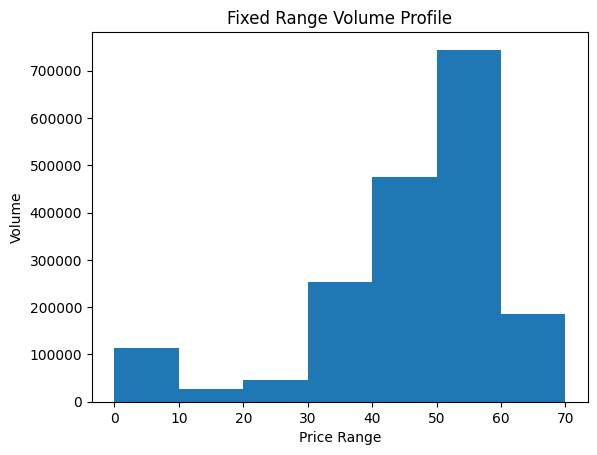

In [667]:
import matplotlib.pyplot as plt

# Create a bar chart for the volume profile
plt.bar(np.arange(num_ranges) * price_range, volume_profile, width=price_range, align='edge')
plt.xlabel('Price Range')
plt.ylabel('Volume')
plt.title('Fixed Range Volume Profile')
plt.show()


In [668]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go

# Fetch OHLCV data

volume = df_XUD['volume']
close = df_XUD['close']

In [669]:
px.histogram(df_XUD, x='volume', y='close', nbins=25, orientation='h').show()


In [670]:
kde_factor = 0.05
num_samples = 500
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

In [671]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [672]:
min_prom = 1
peaks, peak_props = signal.find_peaks(kdy, prominence=min_prom)
pkx = xr[peaks]
pky = kdy[peaks]

fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name='Peaks', x=pkx, y=pky, mode='markers', marker=pk_marker_args))

# Draw prominence lines
left_base = peak_props['left_bases']
right_base = peak_props['right_bases']
line_x = pkx
line_y0 = pky
line_y1 = pky - peak_props['prominences']

for x, y0, y1 in zip(line_x, line_y0, line_y1):
    fig.add_shape(type='line',
        xref='x', yref='y',
        x0=x, y0=y0, x1=x, y1=y1,
        line=dict(
            color='red',
            width=2,
        )
    )
fig.show()

In [673]:
width_range=1
peaks, peak_props = signal.find_peaks(kdy, prominence=min_prom, width=width_range)

left_ips = peak_props['left_ips']
right_ips = peak_props['right_ips']
width_x0 = xr.min() + (left_ips * ticks_per_sample)
width_x1 = xr.min() + (right_ips * ticks_per_sample)
width_y = peak_props['width_heights']

fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name='Peaks', x=pkx, y=pky, mode='markers', marker=pk_marker_args))

for x0, x1, y in zip(width_x0, width_x1, width_y):
    fig.add_shape(type='line',
        xref='x', yref='y',
        x0=x0, y0=y, x1=x1, y1=y,
        line=dict(
            color='red',
            width=2,
        )
    )
fig.show()

In [674]:
pipsize = 0.0001
max_width_pips = 20
min_prom = kdy.max() * 0.3
width_range=(1, max_width_pips * pipsize / ticks_per_sample)
peaks, peak_props = signal.find_peaks(kdy, width=width_range, prominence=min_prom)
pkx = xr[peaks]
pky = kdy[peaks]

In [675]:
min_prom = kdy.max() * 0.3
peaks, peak_props = signal.find_peaks(kdy, prominence=min_prom)

left_base = peak_props['left_bases']
right_base = peak_props['right_bases']
int_from = xr.min() + (left_base * ticks_per_sample)
int_to = xr.min() + (right_base * ticks_per_sample)

[kde.integrate_box_1d(x0, x1) for x0, x1 in zip(int_from, int_to)]

[0.9428632215133814]